In [5]:
import math
import time
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold


# ============================================================
# 1. SCALING
# ============================================================
def compute_minmax(X):
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    return mins, maxs


def apply_minmax(X, mins, maxs):
    return (X - mins) / (maxs - mins + 1e-9)


# ============================================================
# 2. DISTANCES & KNN (FROM SCRATCH)
# ============================================================
def euclidean(a, b):
    return math.sqrt(np.sum((a - b) ** 2))


def manhattan(a, b):
    return np.sum(np.abs(a - b))


def knn_predict_single(X_train, y_train, x, k, metric="euclidean"):
    if metric == "euclidean":
        dist_fn = euclidean
    elif metric == "manhattan":
        dist_fn = manhattan
    else:
        raise ValueError(f"Unknown metric: {metric}")

    dists = []
    for xi, yi in zip(X_train, y_train):
        d = dist_fn(x, xi)
        dists.append((d, yi))

    # En yakın k komşu
    dists.sort(key=lambda t: t[0])
    k_neighbors = [lab for _, lab in dists[:k]]

    # Çoğunluk oylama
    counts = Counter(k_neighbors)
    pred_label = counts.most_common(1)[0][0]
    return pred_label


def knn_predict(X_train, y_train, X_test, k, metric="euclidean"):
    preds = []
    for x in X_test:
        preds.append(knn_predict_single(X_train, y_train, x, k, metric))
    return np.array(preds, dtype=int)


# ============================================================
# 3. METRİKLER
# ============================================================
def confusion_binary(y_true, y_pred):
    tp = fp = fn = tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == 0 and yp == 0:
            tn += 1
        elif yt == 0 and yp == 1:
            fp += 1
        elif yt == 1 and yp == 0:
            fn += 1
    return tp, fp, fn, tn


def evaluate_and_print(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    tp, fp, fn, tn = confusion_binary(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
def print_results_table(dataset_name, best_k_euclidean, best_k_manhattan,
                        metrics_fs_euclidean, metrics_fs_manhattan,
                        metrics_sk_euclidean, metrics_sk_manhattan,
                        elapsed_fs_euclidean=None, elapsed_fs_manhattan=None,
                        save_csv=False, csv_path=None):
    import pandas as pd

    rows = [
        {
            "Dataset": dataset_name,
            "Impl": "From-Scratch",
            "Metric": "Euclidean",
            "k": best_k_euclidean,
            "Accuracy": metrics_fs_euclidean["Accuracy"],
            "Precision": metrics_fs_euclidean["Precision"],
            "Recall": metrics_fs_euclidean["Recall"],
            "F1": metrics_fs_euclidean["F1-Score"],
            "PredictTimeSec": elapsed_fs_euclidean
        },
        {
            "Dataset": dataset_name,
            "Impl": "From-Scratch",
            "Metric": "Manhattan",
            "k": best_k_manhattan,
            "Accuracy": metrics_fs_manhattan["Accuracy"],
            "Precision": metrics_fs_manhattan["Precision"],
            "Recall": metrics_fs_manhattan["Recall"],
            "F1": metrics_fs_manhattan["F1-Score"],
            "PredictTimeSec": elapsed_fs_manhattan
        },
        {
            "Dataset": dataset_name,
            "Impl": "Sklearn",
            "Metric": "Euclidean",
            "k": best_k_euclidean,
            "Accuracy": metrics_sk_euclidean["Accuracy"],
            "Precision": metrics_sk_euclidean["Precision"],
            "Recall": metrics_sk_euclidean["Recall"],
            "F1": metrics_sk_euclidean["F1-Score"],
            "PredictTimeSec": None
        },
        {
            "Dataset": dataset_name,
            "Impl": "Sklearn",
            "Metric": "Manhattan",
            "k": best_k_manhattan,
            "Accuracy": metrics_sk_manhattan["Accuracy"],
            "Precision": metrics_sk_manhattan["Precision"],
            "Recall": metrics_sk_manhattan["Recall"],
            "F1": metrics_sk_manhattan["F1-Score"],
            "PredictTimeSec": None
        },
    ]

    df_res = pd.DataFrame(rows)

    # Daha okunur sıralama
    df_res["Impl"] = pd.Categorical(df_res["Impl"], categories=["From-Scratch", "Sklearn"], ordered=True)
    df_res["Metric"] = pd.Categorical(df_res["Metric"], categories=["Euclidean", "Manhattan"], ordered=True)
    df_res = df_res.sort_values(["Impl", "Metric"]).reset_index(drop=True)

    # Print (tek seferde tablo)
    print("\n" + "="*90)
    print(f"SUMMARY TABLE — {dataset_name}")
    print("="*90)
    with pd.option_context("display.max_columns", None, "display.width", 160, "display.float_format", "{:.4f}".format):
        print(df_res)

    # Opsiyonel CSV kayıt
    if save_csv:
        if csv_path is None:
            safe_name = dataset_name.lower().replace(" ", "_").replace("/", "_")
            csv_path = f"knn_summary_{safe_name}.csv"
        df_res.to_csv(csv_path, index=False)
        print(f"\nSaved summary CSV -> {csv_path}")

    return df_res

# ============================================================
# 4. K-FOLD CV (HER METRIC İÇİN AYRI EN İYİ k SEÇİMİ)
# ============================================================
def k_fold_scores(X, y, k_values, metric="euclidean", folds=5, seed=42):
    """
    Stratified K-Fold CV:
    - Her fold'da sınıf oranlarını korur (stratified).
    - Scaling sadece train fold'a göre yapılır, val fold train istatistikleriyle ölçeklenir.
    - Her k için ortalama accuracy döner.
    """
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    scores = {k: [] for k in k_values}

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Scaling sadece fold train'ine göre
        mins, maxs = compute_minmax(X_train_fold)
        X_train_scaled = apply_minmax(X_train_fold, mins, maxs)
        X_val_scaled = apply_minmax(X_val_fold, mins, maxs)

        for k in k_values:
            preds = knn_predict(X_train_scaled, y_train_fold, X_val_scaled, k, metric=metric)
            acc = np.mean(preds == y_val_fold)
            scores[k].append(acc)

    avg_scores = {k: float(np.mean(v)) for k, v in scores.items()}
    return avg_scores

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# -----------------------------
# METRİK HESAPLAMA
# -----------------------------
def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        if y_proba.ndim > 1:
            pos_proba = y_proba[:, 1]
        else:
            pos_proba = y_proba
        metrics["ROC-AUC"] = roc_auc_score(y_true, pos_proba)
    else:
        metrics["ROC-AUC"] = None
    return metrics


def print_metrics_table(metrics, title="Results"):
    print(f"\n{title}:")
    print("-" * 40)
    for k, v in metrics.items():
        if v is None:
            print(f"{k:12s}: None")
        else:
            print(f"{k:12s}: {v:.4f}")


# -----------------------------
# CONFUSION MATRIX HEATMAP
# -----------------------------
def plot_confusion_matrix_heatmap(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    classes = ["0", "1"]
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()


# -----------------------------
# ROC CURVE
# -----------------------------
def plot_roc_curve_model(y_true, y_proba, title="ROC Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    fpr, tpr, _ = roc_curve(y_true, pos_proba)
    auc = roc_auc_score(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# PRECISION–RECALL CURVE
# -----------------------------
def plot_precision_recall_curve_model(y_true, y_proba, title="Precision-Recall Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    precision, recall, _ = precision_recall_curve(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# METRİK BAR CHART
# -----------------------------
def plot_metrics_bar(metrics, title="Model Performance"):
    names = [k for k in metrics.keys() if metrics[k] is not None]
    values = [metrics[k] for k in names]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(names, values)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 0.01,
            f"{h:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()
def compute_metrics_with_proba_knn(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }

# ============================================================
# 5. TEK DATASET İÇİN TÜM PIPELINE (FROM-SCRATCH KNN)
# ============================================================
def run_knn_pipeline(X_train_df, X_test_df, y_train_ser, y_test_ser, dataset_name, random_seed=42):
    """
    X_train_df, X_test_df : pandas DataFrame (features)
    y_train_ser, y_test_ser: pandas Series (0/1 target)
    dataset_name           : string, sadece print için
    """
    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_name}")
    print(f"Train size: {len(X_train_df)}")
    print(f"Test size : {len(X_test_df)}")
    print("="*60)

    # DataFrame -> numpy
    X_train_raw = X_train_df.to_numpy(dtype=float)
    X_test_raw = X_test_df.to_numpy(dtype=float)
    y_train = y_train_ser.to_numpy(dtype=int)
    y_test = y_test_ser.to_numpy(dtype=int)

    # k listesi
    k_list = [1, 5, 9, 13, 17, 21]

    # --- CV: Euclidean ---
    print("CV başlıyor (Euclidean)...")
    scores_euclidean = k_fold_scores(
        X_train_raw, y_train, k_list,
        metric="euclidean", folds=5, seed=random_seed
    )
    best_k_euclidean = max(scores_euclidean, key=scores_euclidean.get)
    print("Euclidean CV Scores:", scores_euclidean)
    print("Best k (Euclidean):", best_k_euclidean)
    print("-" * 50)

    # --- CV: Manhattan ---
    print("CV başlıyor (Manhattan)...")
    scores_manhattan = k_fold_scores(
        X_train_raw, y_train, k_list,
        metric="manhattan", folds=5, seed=random_seed
    )
    best_k_manhattan = max(scores_manhattan, key=scores_manhattan.get)
    print("Manhattan CV Scores:", scores_manhattan)
    print("Best k (Manhattan):", best_k_manhattan)
    print("-" * 50)

    # --- Final scaling train'e göre ---
    mins, maxs = compute_minmax(X_train_raw)
    X_train = apply_minmax(X_train_raw, mins, maxs)
    X_test = apply_minmax(X_test_raw, mins, maxs)

    # ======================================================================
    # FROM-SCRATCH KNN — EUCLIDEAN
    # ======================================================================
    start = time.time()
    y_pred_fs_euclidean = knn_predict(
        X_train, y_train, X_test,
        best_k_euclidean, metric="euclidean"
    )
    elapsed_fs_euclidean = time.time() - start
    metrics_fs_euclidean = compute_metrics_with_proba_knn(
        y_test, y_pred_fs_euclidean
    )
    evaluate_and_print(
        y_test, y_pred_fs_euclidean,
        f"[{dataset_name}] FROM-SCRATCH KNN (Euclidean, k={best_k_euclidean})"
    )
    print(f"Predict time (From-scratch Euclidean): {elapsed_fs_euclidean:.4f} seconds")

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_fs_euclidean,
        title=f"{dataset_name} - FS KNN Euclidean Confusion Matrix")
    plot_metrics_bar(metrics_fs_euclidean,
        title=f"{dataset_name} - FS KNN Euclidean Metrics")

    # ======================================================================
    # FROM-SCRATCH KNN — MANHATTAN
    # ======================================================================
    start = time.time()
    y_pred_fs_manhattan = knn_predict(
        X_train, y_train, X_test,
        best_k_manhattan, metric="manhattan"
    )
    elapsed_fs_manhattan = time.time() - start
    metrics_fs_manhattan = compute_metrics_with_proba_knn(
        y_test, y_pred_fs_manhattan
    )
    evaluate_and_print(
        y_test, y_pred_fs_manhattan,
        f"[{dataset_name}] FROM-SCRATCH KNN (Manhattan, k={best_k_manhattan})"
    )
    print(f"Predict time (From-scratch Manhattan): {elapsed_fs_manhattan:.4f} seconds")

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_fs_manhattan,
        title=f"{dataset_name} - FS KNN Manhattan Confusion Matrix")
    plot_metrics_bar(metrics_fs_manhattan,
        title=f"{dataset_name} - FS KNN Manhattan Metrics")

    # ======================================================================
    # SKLEARN KNN — EUCLIDEAN
    # ======================================================================
    sk_knn_euclidean = KNeighborsClassifier(
        n_neighbors=best_k_euclidean,
        metric="euclidean"
    )
    sk_knn_euclidean.fit(X_train, y_train)
    y_pred_sk_euclidean = sk_knn_euclidean.predict(X_test)

    metrics_sk_euclidean = compute_metrics_with_proba_knn(
        y_test, y_pred_sk_euclidean
    )
    evaluate_and_print(
        y_test, y_pred_sk_euclidean,
        f"[{dataset_name}] SKLEARN KNN (Euclidean, k={best_k_euclidean})"
    )

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_sk_euclidean,
        title=f"{dataset_name} - Sklearn KNN Euclidean Confusion Matrix")
    plot_metrics_bar(metrics_sk_euclidean,
        title=f"{dataset_name} - SK KNN Euclidean Metrics")

    # ======================================================================
    # SKLEARN KNN — MANHATTAN
    # ======================================================================
    sk_knn_manhattan = KNeighborsClassifier(
        n_neighbors=best_k_manhattan,
        metric="manhattan"
    )
    sk_knn_manhattan.fit(X_train, y_train)
    y_pred_sk_manhattan = sk_knn_manhattan.predict(X_test)

    metrics_sk_manhattan = compute_metrics_with_proba_knn(
        y_test, y_pred_sk_manhattan
    )
    evaluate_and_print(
        y_test, y_pred_sk_manhattan,
        f"[{dataset_name}] SKLEARN KNN (Manhattan, k={best_k_manhattan})"
    )

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_sk_manhattan,
        title=f"{dataset_name} - Sklearn KNN Manhattan Confusion Matrix")
    plot_metrics_bar(metrics_sk_manhattan,
        title=f"{dataset_name} - SK KNN Manhattan Metrics")

    print(f"\n[{dataset_name}] from-scratch KNN vs sklearn KNN karşılaştırması tamam.")
    summary_df = print_results_table(
        dataset_name=dataset_name,
        best_k_euclidean=best_k_euclidean,
        best_k_manhattan=best_k_manhattan,
        metrics_fs_euclidean=metrics_fs_euclidean,
        metrics_fs_manhattan=metrics_fs_manhattan,
        metrics_sk_euclidean=metrics_sk_euclidean,
        metrics_sk_manhattan=metrics_sk_manhattan,
        elapsed_fs_euclidean=elapsed_fs_euclidean,
        elapsed_fs_manhattan=elapsed_fs_manhattan,
        save_csv=False  # True yaparsan otomatik CSV kaydeder
    )
    return {
        "fs_euclidean": metrics_fs_euclidean,
        "fs_manhattan": metrics_fs_manhattan,
        "sk_euclidean": metrics_sk_euclidean,
        "sk_manhattan": metrics_sk_manhattan,
        "summary_table": summary_df
    }



DATASET: UCI Heart Disease (unscaled)
Train size: 736
Test size : 184
CV başlıyor (Euclidean)...
Euclidean CV Scores: {1: 0.8084574370288655, 5: 0.8125298768155911, 9: 0.8070968928111786, 13: 0.8070693142121714, 17: 0.7989060489060489, 21: 0.794815223386652}
Best k (Euclidean): 5
--------------------------------------------------
CV başlıyor (Manhattan)...
Manhattan CV Scores: {1: 0.8125206839492554, 5: 0.8233590733590732, 9: 0.8260893546607833, 13: 0.8288288288288289, 17: 0.8342250413678987, 21: 0.8274315131457989}
Best k (Manhattan): 17
--------------------------------------------------

=== [UCI Heart Disease (unscaled)] FROM-SCRATCH KNN (Euclidean, k=5) ===
Accuracy : 0.8750
Precision: 0.8911
Recall   : 0.8824
F1-Score : 0.8867
TP=90, FP=11, FN=12, TN=71
Predict time (From-scratch Euclidean): 0.2143 seconds


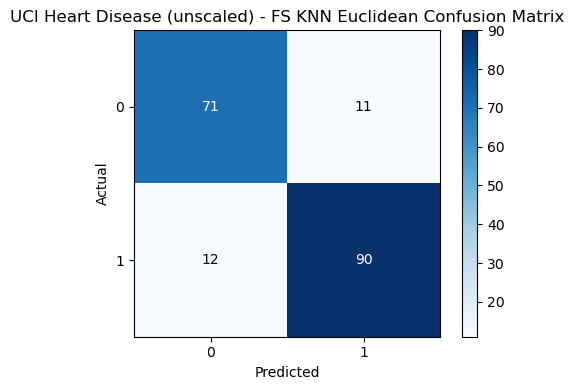

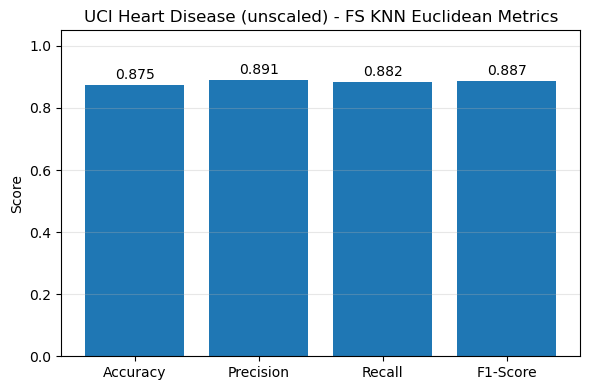


=== [UCI Heart Disease (unscaled)] FROM-SCRATCH KNN (Manhattan, k=17) ===
Accuracy : 0.8478
Precision: 0.8776
Recall   : 0.8431
F1-Score : 0.8600
TP=86, FP=12, FN=16, TN=70
Predict time (From-scratch Manhattan): 0.2375 seconds


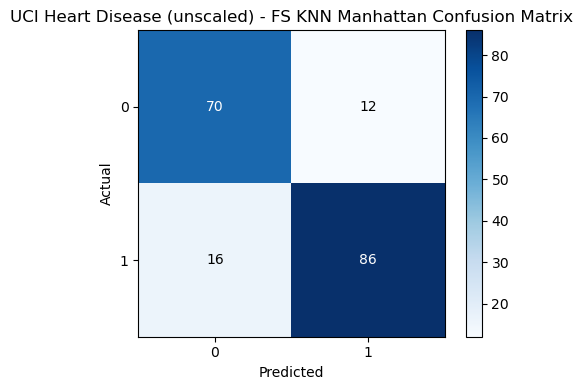

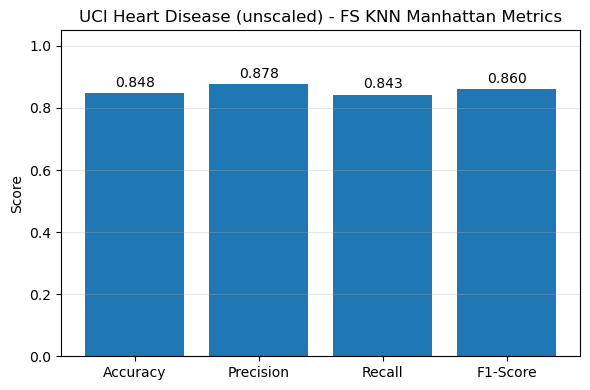


=== [UCI Heart Disease (unscaled)] SKLEARN KNN (Euclidean, k=5) ===
Accuracy : 0.8750
Precision: 0.8911
Recall   : 0.8824
F1-Score : 0.8867
TP=90, FP=11, FN=12, TN=71


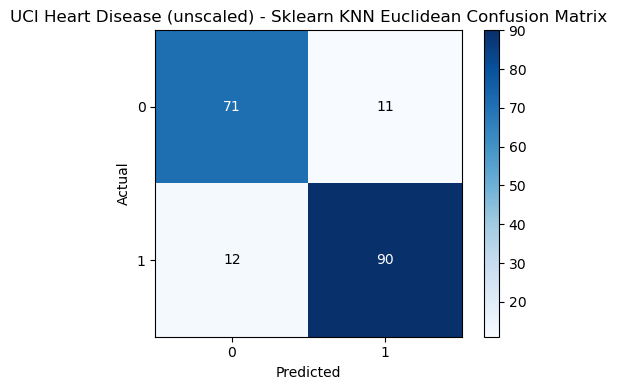

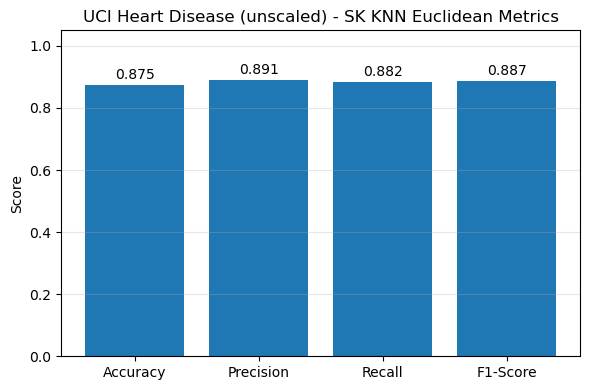


=== [UCI Heart Disease (unscaled)] SKLEARN KNN (Manhattan, k=17) ===
Accuracy : 0.8478
Precision: 0.8776
Recall   : 0.8431
F1-Score : 0.8600
TP=86, FP=12, FN=16, TN=70


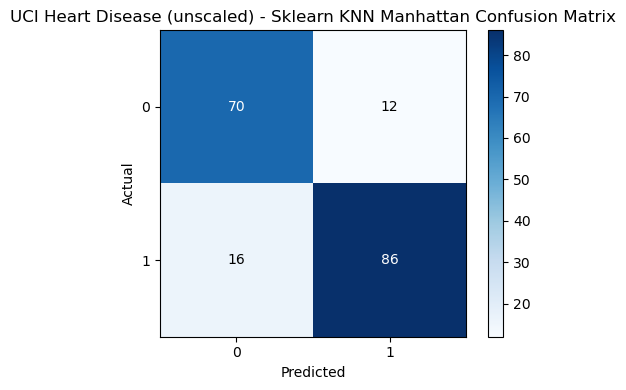

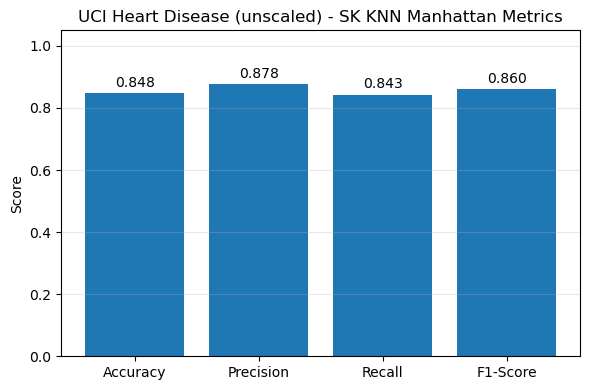


[UCI Heart Disease (unscaled)] from-scratch KNN vs sklearn KNN karşılaştırması tamam.

SUMMARY TABLE — UCI Heart Disease (unscaled)
                        Dataset          Impl     Metric   k  Accuracy  Precision  Recall     F1  PredictTimeSec
0  UCI Heart Disease (unscaled)  From-Scratch  Euclidean   5    0.8750     0.8911  0.8824 0.8867          0.2143
1  UCI Heart Disease (unscaled)  From-Scratch  Manhattan  17    0.8478     0.8776  0.8431 0.8600          0.2375
2  UCI Heart Disease (unscaled)       Sklearn  Euclidean   5    0.8750     0.8911  0.8824 0.8867             NaN
3  UCI Heart Disease (unscaled)       Sklearn  Manhattan  17    0.8478     0.8776  0.8431 0.8600             NaN

DATASET: Heart Failure Kaggle (unscaled)
Train size: 734
Test size : 184
CV başlıyor (Euclidean)...
Euclidean CV Scores: {1: 0.8105768334731153, 5: 0.846081446277141, 9: 0.8406672257944272, 13: 0.8474699468828628, 17: 0.8433696766377784, 21: 0.8501723977262138}
Best k (Euclidean): 21
----------------

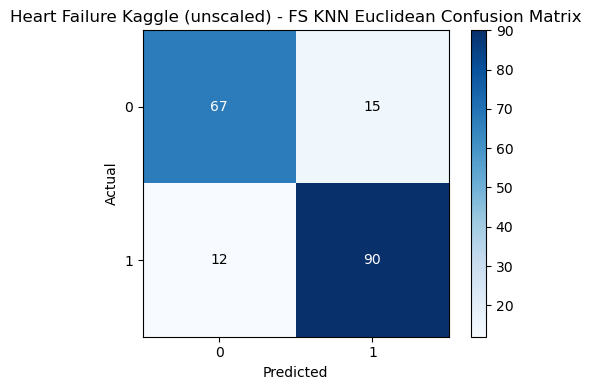

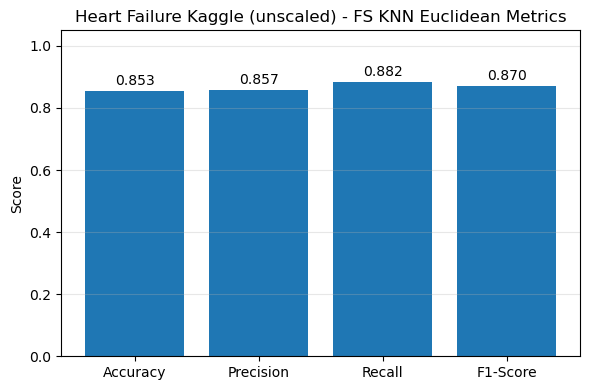


=== [Heart Failure Kaggle (unscaled)] FROM-SCRATCH KNN (Manhattan, k=5) ===
Accuracy : 0.8859
Precision: 0.8785
Recall   : 0.9216
F1-Score : 0.8995
TP=94, FP=13, FN=8, TN=69
Predict time (From-scratch Manhattan): 0.2375 seconds


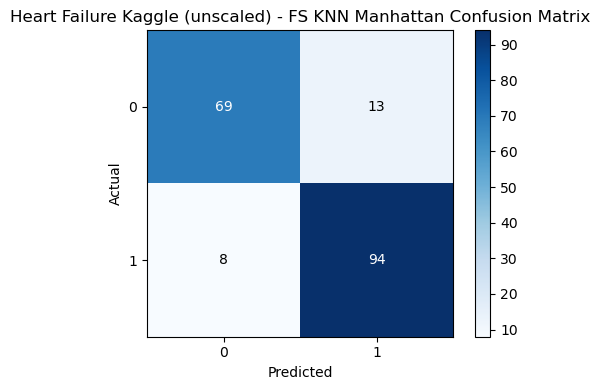

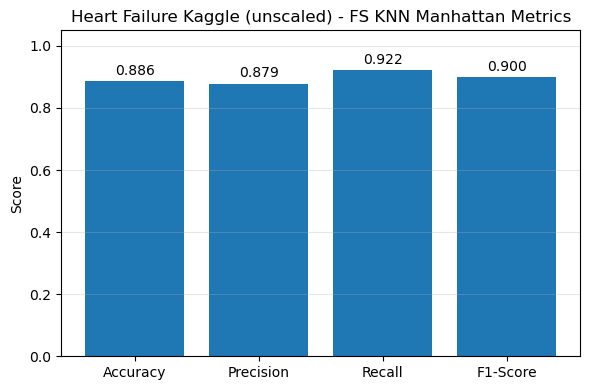


=== [Heart Failure Kaggle (unscaled)] SKLEARN KNN (Euclidean, k=21) ===
Accuracy : 0.8533
Precision: 0.8571
Recall   : 0.8824
F1-Score : 0.8696
TP=90, FP=15, FN=12, TN=67


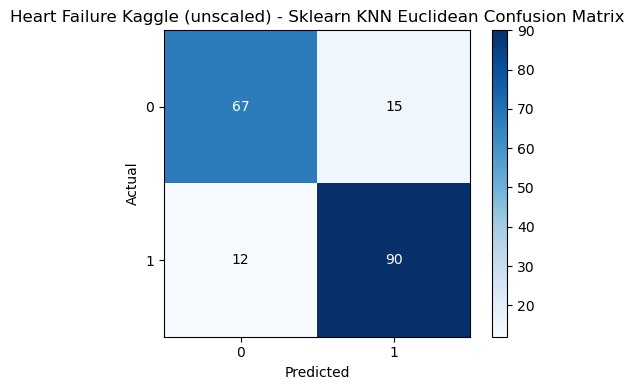

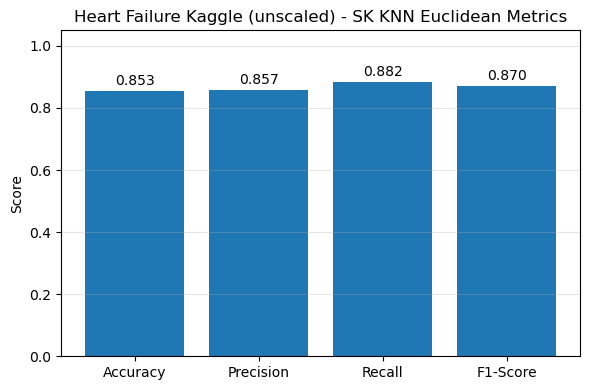


=== [Heart Failure Kaggle (unscaled)] SKLEARN KNN (Manhattan, k=5) ===
Accuracy : 0.8859
Precision: 0.8785
Recall   : 0.9216
F1-Score : 0.8995
TP=94, FP=13, FN=8, TN=69


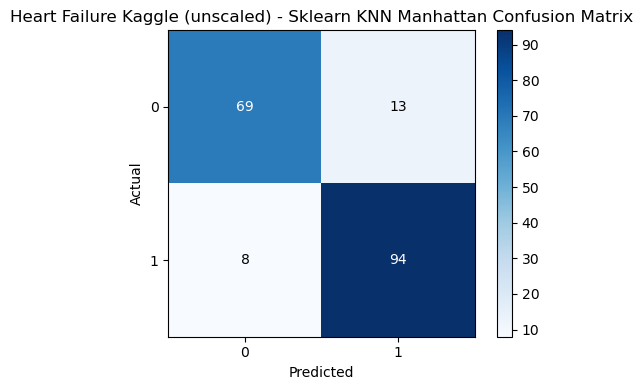

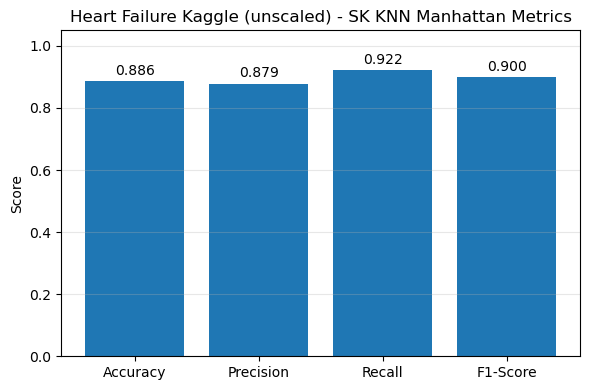


[Heart Failure Kaggle (unscaled)] from-scratch KNN vs sklearn KNN karşılaştırması tamam.

SUMMARY TABLE — Heart Failure Kaggle (unscaled)
                           Dataset          Impl     Metric   k  Accuracy  Precision  Recall     F1  PredictTimeSec
0  Heart Failure Kaggle (unscaled)  From-Scratch  Euclidean  21    0.8533     0.8571  0.8824 0.8696          0.2288
1  Heart Failure Kaggle (unscaled)  From-Scratch  Manhattan   5    0.8859     0.8785  0.9216 0.8995          0.2375
2  Heart Failure Kaggle (unscaled)       Sklearn  Euclidean  21    0.8533     0.8571  0.8824 0.8696             NaN
3  Heart Failure Kaggle (unscaled)       Sklearn  Manhattan   5    0.8859     0.8785  0.9216 0.8995             NaN


{'fs_euclidean': {'Accuracy': 0.8532608695652174,
  'Precision': 0.8571428571428571,
  'Recall': 0.8823529411764706,
  'F1-Score': 0.8695652173913043},
 'fs_manhattan': {'Accuracy': 0.8858695652173914,
  'Precision': 0.8785046728971962,
  'Recall': 0.9215686274509803,
  'F1-Score': 0.8995215311004785},
 'sk_euclidean': {'Accuracy': 0.8532608695652174,
  'Precision': 0.8571428571428571,
  'Recall': 0.8823529411764706,
  'F1-Score': 0.8695652173913043},
 'sk_manhattan': {'Accuracy': 0.8858695652173914,
  'Precision': 0.8785046728971962,
  'Recall': 0.9215686274509803,
  'F1-Score': 0.8995215311004785},
 'summary_table':                            Dataset          Impl     Metric   k  Accuracy  \
 0  Heart Failure Kaggle (unscaled)  From-Scratch  Euclidean  21  0.853261   
 1  Heart Failure Kaggle (unscaled)  From-Scratch  Manhattan   5  0.885870   
 2  Heart Failure Kaggle (unscaled)       Sklearn  Euclidean  21  0.853261   
 3  Heart Failure Kaggle (unscaled)       Sklearn  Manhattan   

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ============================================================
# 6. İKİ FARKLI DATASET İÇİN PIPELINE ÇALIŞTIR (LEAKAGE-FREE)
# ============================================================

# 1) Dataset-1 (UNSCALED)
df1 = pd.read_csv("preprocessed_heart_disease_uci_unscaled.csv")
X1 = df1.drop("target", axis=1)
y1 = df1["target"]

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)

run_knn_pipeline(X1_train, X1_test, y1_train, y1_test, dataset_name="UCI Heart Disease (unscaled)")


# 2) Dataset-2 (UNSCALED)
df2 = pd.read_csv("processed_heart_unscaled.csv")
X2 = df2.drop("HeartDisease", axis=1)
y2 = df2["HeartDisease"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

run_knn_pipeline(X2_train, X2_test, y2_train, y2_test, dataset_name="Heart Failure Kaggle (unscaled)")